<center><img src="img/skillfactorylogo.png"></center>

<h1><center>Курс "Практический Machine Learning"</center></h1>
<h3><center>Шестаков Андрей</center></h3>
<hr>
<h2><center>Деревья решений</center></h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import pydot
from IPython.display import Image

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18,12)

from ipywidgets import interact, IntSlider, FloatSlider

# Пример 1 - алгоритм принятния решений

* Вы приходите в банк за кредитом ~~не дай бог~~, подаете анкету со всеми необходимыми документами
* Сотрудник банка проверяет вашу анкету:
    1. Если объем сбережений <= 200 тыс., то перейти к шагу 2, иначе - к шагу 3.
    2. Если стаж больше года - дать кредит, иначе - не давать
    3. Если продолжительность займа < 30 месяцев - не давать кредит, иначе - к шагу 4
    4. ...

<center><img src='https://www.mapr.com/sites/default/files/blogimages/creditdecisiontree.png'><center/>

# Пример 2 - Играть или не играть?

<center><img src='https://i.stack.imgur.com/KYSy4.png'></center>

<img src='img/Decision_tree_model.png'>

# Пример 3 - описание сегментов

<center><img src='https://static01.nyt.com/images/2008/04/16/us/0416-nat-subOBAMA.jpg'><center/>

Формально, дерево решений - это связный ациклический граф. В нем можно выделить 3 типа вершин:
1. Корневая вершина (root node) -  откуда все начинается
2. Внутренние вершины (intermediate nodes)
3. Листья (leafs) - самые глубокие вершины дерева, в которых содержится "ответ"

Во внутренней или коневой вершине признак проверяется на некий логический критерий, по результатам которого мы движемся все глубже

## Как определяются лучшие разбиения (best splits)?
### Меры неопределенности (impurity measures)

По какому мешку лучше классифицировать?

<center><img src='img\bins.png'></center>


## Как определяются лучшие разбиения (best splits)?
### Меры неопределенности (impurity measures)

Пусть $p_k$ - это доля класса $C_k$ в узле дерева $S$.

1. Missclassification error  
$$I(S) = 1 - \max\limits_k p_k $$
2. Gini index 
$$I(S) = 1 - \sum\limits_k (p_k)^2 = \sum\limits_{k'\neq k} p_{k'} p_k$$
3. Entropy 
$$I(S) = -\sum\limits_k p_k \log(p_k)$$


In [2]:
def plot_impurities():
    p = np.linspace(0, 1, 100)
    p = np.c_[p, 1-p]

    missclass = 1 - p.max(axis=1)
    plt.plot(p[:,0], missclass, label = 'missclassification error')

    gini = 1 - (p ** 2).sum(axis=1)
    plt.plot(p[:,0], gini, label = 'gini index')

    entropy = - np.nansum((p*np.log2(p)), axis=1)
    plt.plot(p[:,0], entropy, label = 'entropy')

    plt.xlabel('$p_k$')
    plt.ylabel('$I(S)$')
    # plt.legend(loc=2, bbox_to_anchor=(0.,0.))
    plt.legend(loc=2, bbox_to_anchor=(-0.3,1))
    
    plt.show()

<ipython-input-2-7d6e1f8fd62d>:11: RuntimeWarning: divide by zero encountered in log2
  entropy = - np.nansum((p*np.log2(p)), axis=1)
<ipython-input-2-7d6e1f8fd62d>:11: RuntimeWarning: invalid value encountered in multiply
  entropy = - np.nansum((p*np.log2(p)), axis=1)


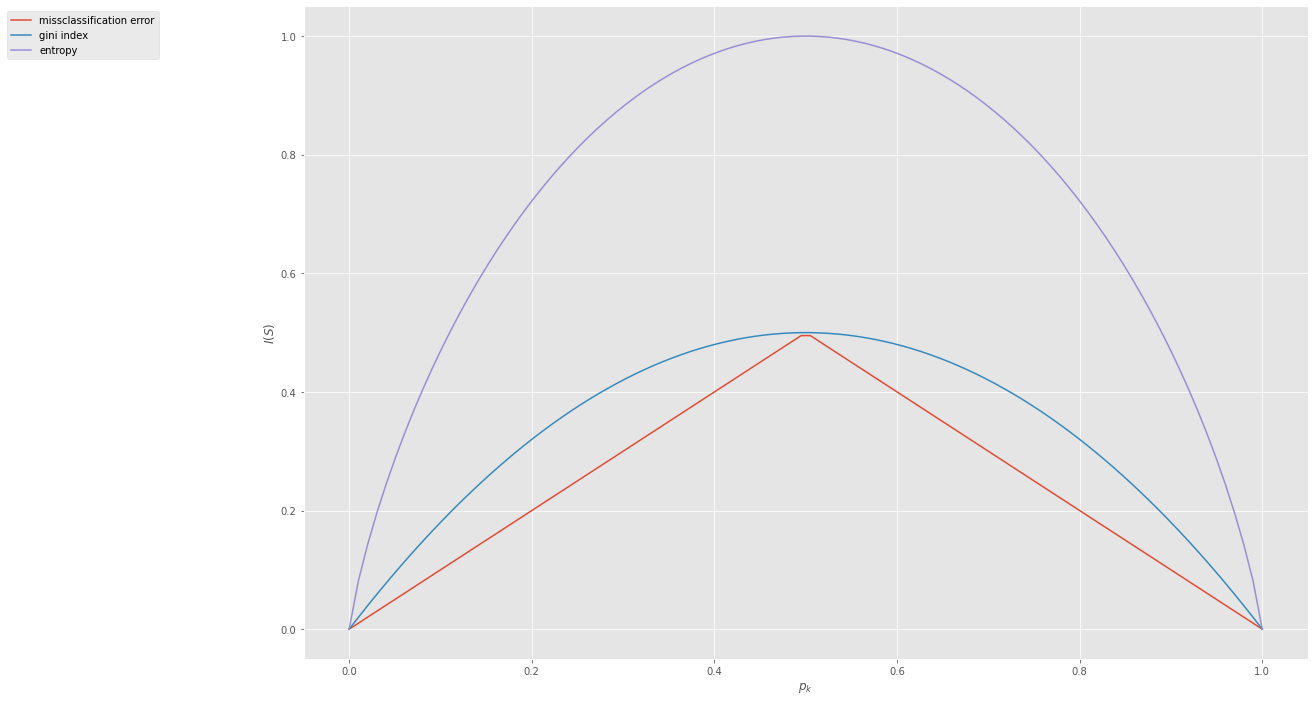

In [3]:
plot_impurities()

## Как определяются лучшие разбиения (best splits)?
### Прирост информации

Выберем признак $A$ и пороговое значение $t$ на нем таким образом, чтобы уменьшить неопределенность:

**Насколько уменьшится неопределенность:** <br/>
$$ Gain(S, A) = I(S) - \left(\frac{|S_L|}{|S|}\cdot I(S_L) + \frac{|S_R|}{|S|}\cdot I(S_R) \right),$$ где $S_R$ и $S_L$ - это потомки узла $S$ c объектами, удовлетворяющим соответствующим условиям.

* Стратегия выбора - жадная
* Как определяется порог при вещественных признаках?
* Локальная оптимизация - уменьшение Impurity внутри узла
* Результаты не сильно зависят от выбора самой меры неопределенности


In [4]:
def gini_impurity(p):
    return 1 - (p**2).sum()

def wine_demo():

    df_wine = pd.read_csv('data/winequality-red.csv', sep=';')

    fig, ax = plt.subplots(1, 2)

    fig.set_figheight(5)

    df_wine.loc[:, 'quality_cat'] = (df_wine.loc[:, 'quality'] > 5).astype(int) 
    idx = df_wine.loc[:, 'quality_cat'] == 1
    df_wine.loc[idx, 'alcohol'].hist(label='good quality', bins=20, alpha = 0.4, ax=ax[0])
    df_wine.loc[~idx, 'alcohol'].hist(label='bad quality', bins=20, alpha = 0.4, ax=ax[0])
    ax[0].set_xlabel('alcohol')

    p = np.array([df_wine.quality_cat.mean(), 1-df_wine.quality_cat.mean()])

    init_impurity = gini_impurity(p)

    G = []
    t_range = np.linspace(df_wine.alcohol.min(), df_wine.alcohol.max(), 100)

    for t in t_range:
        idx = df_wine.alcohol < t
        p1 = np.array([df_wine.loc[idx, 'quality_cat'].mean(), 1-df_wine.loc[idx, 'quality_cat'].mean()])
        p2 = np.array([df_wine.loc[~idx, 'quality_cat'].mean(), 1-df_wine.loc[~idx, 'quality_cat'].mean()])

        G.append(init_impurity - (idx.mean()*gini_impurity(p1) + (1-idx.mean())*gini_impurity(p2)))

    ax[1].plot(t_range, G)
    ax[1].set_xlabel('alcohol')
    ax[1].set_ylabel('Gain')

    mG = np.nanmax(G)
    mt = t_range[np.nanargmax(G)]

    ax[0].vlines(mt, 0, 150, label='best threshold (%.2f)' % mt)
    ax[1].vlines(mt, 0, mG, label='best threshold\n(gain = %.4f)' % mG)
    
    ax[0].legend()
    ax[1].legend()
    
    plt.show()

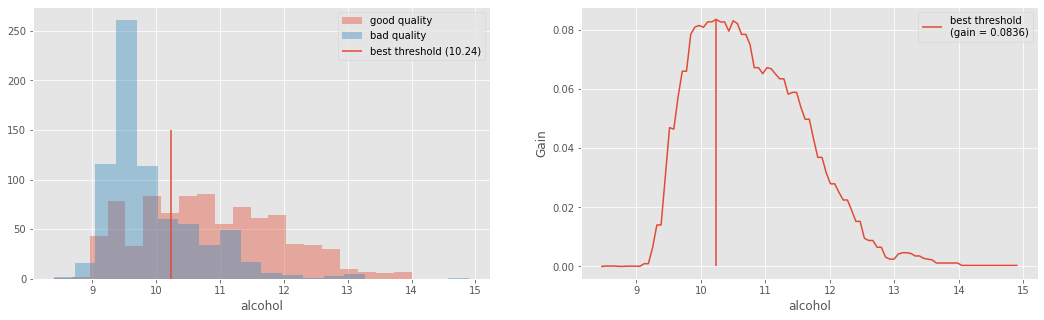

In [5]:
wine_demo() 

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from ipywidgets import interact, IntSlider
import subprocess


def demo_dec_tree(depth=1):
    fig, ax = plt.subplots(1,2)
    fig.set_figheight(5)

    np.random.seed(0)

    C = np.array([[0., -0.7], [1.5, 0.7]])
    gauss1 = np.dot(np.random.randn(200, 2) + np.array([4, 2]), C)
    gauss2 = np.dot(np.random.randn(300, 2), C)

    X = np.vstack([gauss1, gauss2])
    y = np.r_[np.ones(200), np.zeros(300)]

    ax[1].scatter(X[:,0], X[:, 1], c=y)
    ax[1].set_xlabel('$x_1$')
    ax[1].set_ylabel('$x_2$')

    # Dec Tree Stuff
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=123)
    tree.fit(X,y)

    x_range = np.linspace(X.min(), X.max(), 100)
    xx1, xx2 = np.meshgrid(x_range, x_range)

    Y = tree.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Y = Y.reshape(xx1.shape)

    ax[1].contourf(xx1, xx2, Y, alpha=0.3)
    ax[1].scatter(X[:,0], X[:,1],c=y)
    
#     dot_data = StringIO()  
#     tree.export_graphviz(tree, out_file=dot_data,  
#                      filled=True, rounded=True,  
#                      special_characters=True)  
#     graph = pydot.graph_from_dot_data(dot_data.getvalue())  
#     ax[0].imshow(graph[0].create_png())


    with open('tree.dot', 'w') as fout:
        export_graphviz(tree, out_file=fout, feature_names=['x1', 'x2'], class_names=['0', '1'])
    command = ["dot", "-Tpng", "tree.dot", "-o", "tree.png"]
    subprocess.check_call(command)
    ax[0].imshow(plt.imread('tree.png'))
    ax[0].axis("off")
    
    plt.show()

## Классификация

interactive(children=(IntSlider(value=1, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

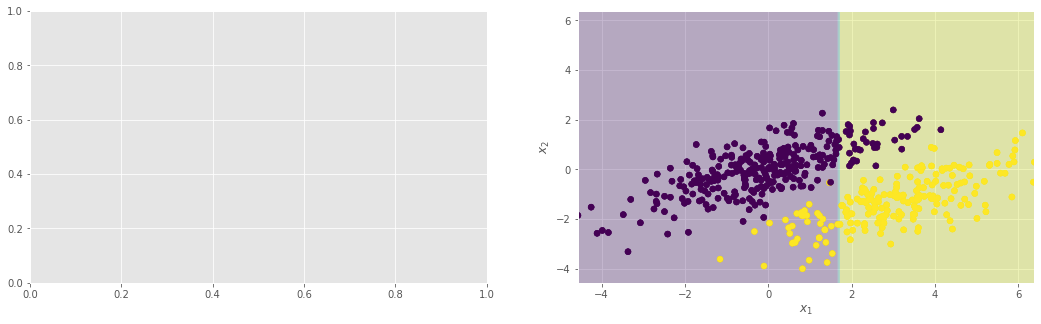

In [7]:
try:
    fig = interact(demo_dec_tree, depth=IntSlider(min=1, max=5, value=1))
except:
    print('Что-то не так. Посмотрите на доску')

## Как определяется ответ?

* Классификация
    * Класс с большинством в листе
    * Доли каждого из классов в листе

## Важность признаков

В деревьях решений производится автоматический отбор признаков.

Пусть $v(S)$ - это признак, который использовался для ветвления в узле $S$

$$ \text{imp}(A) = \sum\limits_{i: v(S_i) = A} \frac{|S_i|}{|S|} Gain(S_i, A) $$

## Работа с пропусками

1. Удалить объекты\признаки с пропусками
2. Пропущенное значение = отдельная категория
3. Surrogate split

## Специальные алгоритмы построения деревьев
 
 
** ID 3 **
* Только категориальные признаки
* Количество потомков = количеству значений признака
* Строится до максимальной глубины

** С 4.5 **
* Поддержка вещественных признаков
* Категриальные как в ID3
* При пропуске значения переход по всем потомкам
* Удаляет избыточные ветвления

** СART **
* В основном сегодняшнее занятие про него
* Специальная процедура усещения дерева после построения (post prunning)

## Преимущества / Недостатки

** Преимущества **
* Простота построения
* Интерпретируемость (при небольшой глубине)
* Требуются минимальная предобработка признаков
* Встроенный отбор признаков



** Недостатки **
* Границы строяется только параллельно или перпендикулярно осям
* При изменении набора данных надо полностью перестраивать и результат может получится совершенно иным
* Жадность построения

See http://www.r2d3.us/visual-intro-to-machine-learning-part-1/

# Данные с оттоком клиентов

Загрузите данные об оттоке клиентов через pandas.

In [8]:
df_churn = pd.read_csv('data/churn.csv')

In [9]:
def preproc(df_init):
    df_preproc = df_init.copy()
    
    # Удалили признаки
    df_preproc = df_preproc.drop(['State', 'Area Code', 'Phone'], axis=1)
    
    # Замена категориальных признаков
    df_preproc.loc[:,  ["Int'l Plan", 'VMail Plan']] = \
    df_preproc.loc[:,  ["Int'l Plan", 'VMail Plan']].replace({'no': 0, 'yes': 1})
    
    df_preproc.loc[:,  'Churn?'] = df_preproc.loc[:,  'Churn?'].replace({'False.': 0,
                                                                         'True.': 1})
    return df_preproc

In [10]:
df_preproc = df_churn.pipe(preproc)

In [11]:
X, y = df_preproc.iloc[:, :-1].values, df_preproc.iloc[:, -1].values

## Кросс-валидация по одному гиперпараметру

Посмотрим, что делает функция `validation_curve`.

In [12]:
try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

try:
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import StratifiedKFold

`validation_curve` позволяе исследовать влияние отдельного гиперпараметра модели на ее качество.

Построим валидационные кривые по гиперпараметру глубина дерева (`max_depth`) остальных гиперпараметрах, зафиксированных на значениях по-умолчанию

In [13]:
model = DecisionTreeClassifier(random_state=123)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=132)

train_scores, valid_scores = validation_curve(model, X, y, 
                                              'max_depth', range(1, 10),
                                              cv=cv, scoring='roc_auc')
# это значит, что мы будем проверять влияние параметра max_depth
# в дапозоне от 1 до 10
# и для этого мы будем использовать 5-fold кросс-валидацию
# с мерой качества mean_absolute_error.
# neg_ потому что по умолчанию в sklearn чем значение меры выше - тем лучше, 
# но в нашем случае нам нужно как раз допускать меньшую ошибку

p:\wd\old\py\skill_factory\venv\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(1, 10) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Посмотрите, что изображает синяя и красная линия

Text(0, 0.5, 'ROC AUC')

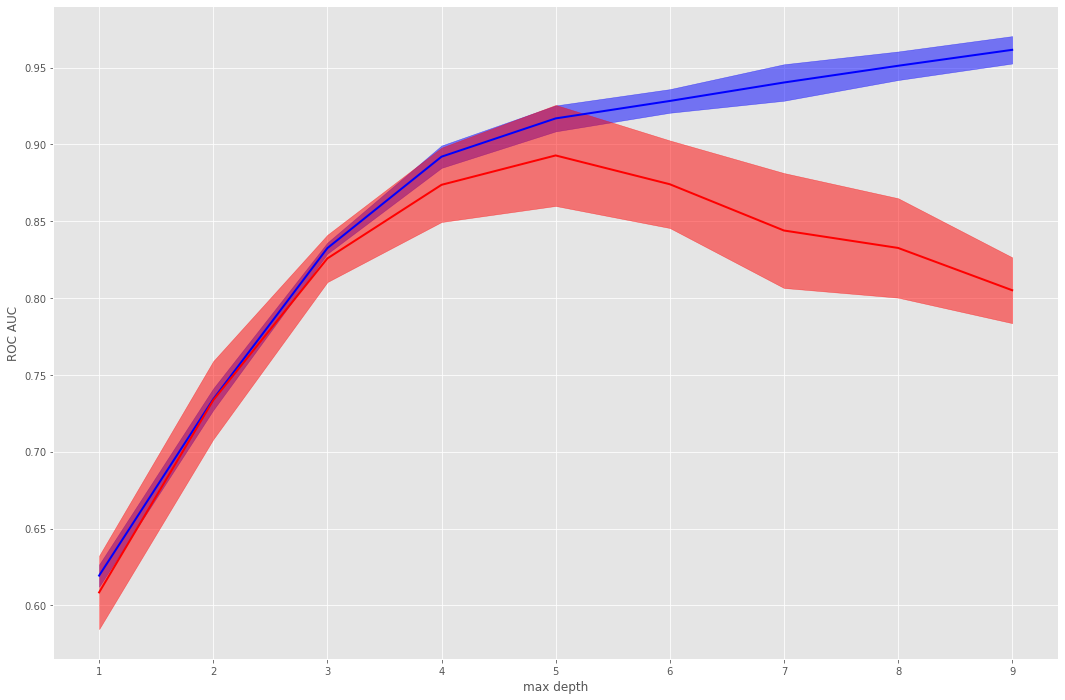

In [14]:
train_score_mean = train_scores.mean(axis=1)
train_score_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

plt.fill_between(range(1,10), train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(range(1,10), valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)

plt.plot(range(1,10), train_score_mean, c='b', lw=2)
plt.plot(range(1,10), valid_scores_mean, c='r', lw=2)

plt.xlabel('max depth')
plt.ylabel('ROC AUC')

## Подбор всех гиперпараметров

Обычно подбирают гиперпараметры целыми группами. Есть несколько способов это делать
* Полный перебор (Grid Search) - явно задаются все возможные значения параметров. Далее перебираются все возможные комбинации этих параметров
* Случайный перебор (Random Search) - для некоотрых параметров задается распределение через функцию распределения. Задается количество случайных комбинаций, которых требуется перебрать.
* "Умный" перебор ([hyperopt](http://hyperopt.github.io/hyperopt/)) - после каждого шага, следующия комбинация выбирается специальным образом, чтобы с одной стороны проверить неисследованные области, а с другой минимизировать функцию потерь. Не всегда работат так хорошо, как звучит.

Мы же попробует случайный поиск. Почему случайный поиск лучше перебора:

<center><img src='https://cdn-images-1.medium.com/max/800/1*ZTlQm_WRcrNqL-nLnx6GJA.png'></center>

In [15]:
from scipy.stats import randint as randint
from scipy.stats import uniform

try:
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import GridSearchCV
    from sklearn.cross_validation import RandomizedSearchCV
    from sklearn.cross_validation import StratifiedKFold


RND_SEED = 123

In [16]:
# Определим пространство поиска

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(2, 8),
    'min_samples_leaf': randint(5, 10),
    'class_weight': [None, 'balanced']}

# Некоторые параметры мы задали не простым перечислением значений, а 
# с помощью распределений.

# Будем делать 200 запусков поиска
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

model = DecisionTreeClassifier(random_state=123)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=200, n_jobs=-1,
                                   cv=cv, scoring='roc_auc', random_state=123)
# А дальше, просто .fit()
random_search.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=123),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x176664C0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x176665B0>},
                   random_state=123, scoring='roc_auc')

In [17]:
random_search.best_params_

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 7}

In [18]:
random_search.best_score_

0.8935353175679749

In [19]:
# Все прогоны. 
p = random_search.grid_scores_[0]

AttributeError: 'RandomizedSearchCV' object has no attribute 'grid_scores_'

## Важность признаков

Возьмем лучшую модель и выведем важность признаков

In [22]:
model = random_search.best_estimator_
data = model.feature_importances_

Каждое число соответствует важности признака, который подавался на вход

Для каждого признака (с названием) получите его значение важности

In [26]:
## Your code here
pd.Series(index=df_preproc.columns[:-1], data=data)

Account Length    0.000000
Int'l Plan        0.144388
VMail Plan        0.044748
VMail Message     0.000000
Day Mins          0.179101
Day Calls         0.000000
Day Charge        0.136677
Eve Mins          0.061488
Eve Calls         0.000000
Eve Charge        0.054535
Night Mins        0.015033
Night Calls       0.003215
Night Charge      0.017428
Intl Mins         0.107851
Intl Calls        0.072566
Intl Charge       0.000000
CustServ Calls    0.162971
dtype: float64

## Визуализация дерева

In [25]:
# dot_data = StringIO()  
# tree.export_graphviz(model, out_file=dot_data, feature_names=feature_names, class_names=['0', '1'], 
#                    filled=True, rounded=True,  special_characters=True)  
# graph = pydot.graph_from_dot_data(dot_data.getvalue())  
# Image(graph[0].create_png())

with open('tree.dot', 'w') as fout:
    export_graphviz(model, out_file=fout, feature_names=feature_names, class_names=['0', '1'], 
                   filled=True, rounded=True,  special_characters=True)
command = ["dot", "-Tpng", "tree.dot", "-o", "tree.png"]
subprocess.check_call(command)
plt.imshow(plt.imread('tree.png'))

FileNotFoundError: [WinError 2] Не удается найти указанный файл

# Дополнительная информация:

[Data Mining and Analysis: Fundamental Concepts and Algorithms](https://repo.palkeo.com/algo/information-retrieval/Data%20mining%20and%20analysis.pdf) Ch 18